In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import cv2
import gc
import copy

import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD,Adam

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [ ]:
# import h5py
# with h5py.File("../data/Xy_small.h5", "r") as f:
# #     print(f.file)
#     X_train = np.array(f['X'])
#     y_train = np.array(f["y"])

In [2]:
import pickle
with open("../data/Xy_small_n100.p", "rb") as f:
    X_train,y_train = pickle.load(f) 

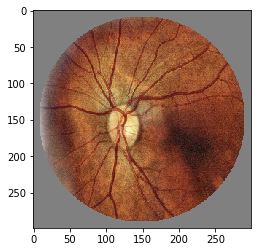

(299, 299, 3) 1


In [3]:
n = 21
plt.imshow(X_train[n][:,:,::-1])
plt.show()
print(X_train[n].shape, y_train[n])

In [4]:
X_train.shape

(100, 299, 299, 3)

----Inception-----


--------
- 18394
- 8:2
- clahe
- sgd
- lr 0.1 reduce 0.5
- batch 40
- epoch 1000
- augment ±10,30
- imagenet

In [5]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

base_model = InceptionV3(include_top = False, 
                               weights = None)
# base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
# for layer in model.layers[:249]:
#     layer.trainable = False
# for layer in model.layers[249:]:
#     layer.trainable = True
for layer in model.layers:
    layer.trainable = True


W1015 13:58:40.686293 139796461881152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/Keras-2.2.5-py3.6.egg/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1015 13:58:40.712365 139796461881152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/Keras-2.2.5-py3.6.egg/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1015 13:58:40.719177 139796461881152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/Keras-2.2.5-py3.6.egg/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1015 13:58:40.745345 139796461881152 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/Keras-2.2.5-py3.6.egg/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated

In [6]:
def train_model_big(model,data,label,batch_size,epoch,lr,model_save_path,log_dir):
    """Train model
    Args: 
        model: a keras model
        data: image data array
        label: label array (without one-hot encoder)
        batch_size
        lr: learning rate
    Return:
        a keras History object
    """
    
    optimizer = keras.optimizers.SGD(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    from keras.utils.np_utils import to_categorical
    label = to_categorical(label, num_classes=2)
    index = int(data.shape[0] * 0.8)
    
    train_X = data[0:index]
    train_y = label[0:index]
    
    valid_X = data[index:]
    valid_y = label[index:]
    
#     flow(self, X, y, batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png')
    train_gen = ImageDataGenerator(rotation_range=30, 
                         width_shift_range= 10.0, 
                         height_shift_range= 10.0, 
                         rescale=1/255)
    valid_gen = ImageDataGenerator(rescale=1/255)
    
    train_generator = train_gen.flow(train_X, 
                     train_y, 
                     batch_size=batch_size, 
                     shuffle=True)
    valid_generator = valid_gen.flow(valid_X, valid_y, batch_size = batch_size)
    
    
#     keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

    tf_record = keras.callbacks.TensorBoard(log_dir=log_dir)
    model_check = keras.callbacks.ModelCheckpoint(filepath = model_save_path, 
                                                  monitor='val_loss', 
                                                  verbose=0, 
                                                  save_best_only=True, 
                                                  save_weights_only=False, mode='auto', period=1)
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

    his = model.fit_generator(train_generator, 
                        steps_per_epoch = train_X.shape[0] // batch_size, 
                        epochs=epoch,
                        validation_data=valid_generator, 
                        validation_steps= valid_X.shape[0] // batch_size, 
                        callbacks = [tf_record, model_check, reduce_lr])
    
    return model,his

In [7]:
for i,layer in enumerate(model.layers):
    print(i,"--->",layer.name,"--->",layer.input_shape,"--->",layer.output_shape)

0 ---> input_1 ---> (None, None, None, 3) ---> (None, None, None, 3)
1 ---> conv2d_1 ---> (None, None, None, 3) ---> (None, None, None, 32)
2 ---> batch_normalization_1 ---> (None, None, None, 32) ---> (None, None, None, 32)
3 ---> activation_1 ---> (None, None, None, 32) ---> (None, None, None, 32)
4 ---> conv2d_2 ---> (None, None, None, 32) ---> (None, None, None, 32)
5 ---> batch_normalization_2 ---> (None, None, None, 32) ---> (None, None, None, 32)
6 ---> activation_2 ---> (None, None, None, 32) ---> (None, None, None, 32)
7 ---> conv2d_3 ---> (None, None, None, 32) ---> (None, None, None, 64)
8 ---> batch_normalization_3 ---> (None, None, None, 64) ---> (None, None, None, 64)
9 ---> activation_3 ---> (None, None, None, 64) ---> (None, None, None, 64)
10 ---> max_pooling2d_1 ---> (None, None, None, 64) ---> (None, None, None, 64)
11 ---> conv2d_4 ---> (None, None, None, 64) ---> (None, None, None, 80)
12 ---> batch_normalization_4 ---> (None, None, None, 80) ---> (None, None, None

In [ ]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [10]:
model_save_path = '../models/inception/weights.{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}.hdf5'
model, his= train_model_big(model,X_train,y_train,40,100,0.1,
                            model_save_path = model_save_path,
                            log_dir = '../logs/inception/')

Epoch 1/100
2/2 [==============================] - 33s 17s/step - loss: 1.6785 - acc: 0.5500 - val_loss: 9.6709 - val_acc: 0.4000
Epoch 2/100
2/2 [==============================] - 25s 13s/step - loss: 2.2274 - acc: 0.4000 - val_loss: 9.6709 - val_acc: 0.4000
Epoch 3/100
2/2 [==============================] - 25s 12s/step - loss: 0.6283 - acc: 0.6000 - val_loss: 9.6709 - val_acc: 0.4000
Epoch 4/100
2/2 [==============================] - 25s 12s/step - loss: 0.6294 - acc: 0.6375 - val_loss: 7.4650 - val_acc: 0.4500
Epoch 5/100
2/2 [==============================] - 25s 13s/step - loss: 0.5866 - acc: 0.6625 - val_loss: 7.1269 - val_acc: 0.5500
Epoch 6/100
2/2 [==============================] - 25s 12s/step - loss: 0.5956 - acc: 0.6875 - val_loss: 3.9971 - val_acc: 0.5500
Epoch 7/100
2/2 [==============================] - 25s 13s/step - loss: 0.5050 - acc: 0.7875 - val_loss: 2.2187 - val_acc: 0.6000
Epoch 8/100
2/2 [==============================] - 25s 12s/step - loss: 0.4241 - acc: 0.82

In [ ]:
model.save('./different_networks/model/weights.165-0.099-0.9920.hdf5')

In [ ]:
gc.collect()

------
- 18394
- 8:2
- clahe
- sgd
- lr 0.1 reduce 0.5
- batch 40
- epoch 1000
- augment ±10,30
- imagenet = None

In [ ]:
train_X = X_train[0:14715]
train_y = y_train[0:14715]
valid_X = X_train[14715:]
valid_y = y_train[14715:]
valid_X = valid_X / 255

In [ ]:
def train_model_big_no_gen(model,train_X,train_y,valid_X,valid_y,batch_size,epoch,lr,model_save_path,log_dir):
    """Train model
    Args: 
        model: a keras model
        data: image data array
        label: label array (without one-hot encoder)
        batch_size
        lr: learning rate
    Return:
        a keras History object
    """
    
    optimizer = keras.optimizers.SGD(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    from keras.utils.np_utils import to_categorical
    train_y = to_categorical(train_y, num_classes=2) 
    valid_y = to_categorical(valid_y, num_classes=2)
#     flow(self, X, y, batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png')
    train_gen = ImageDataGenerator(rotation_range=30, 
                         width_shift_range= 10.0, 
                         height_shift_range= 10.0, 
                         rescale=1/255)
    
    train_generator = train_gen.flow(train_X, 
                     train_y, 
                     batch_size=batch_size, 
                     shuffle=True)
#     keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

    tf_record = keras.callbacks.TensorBoard(log_dir=log_dir)
    model_check = keras.callbacks.ModelCheckpoint(filepath = model_save_path, 
                                                  monitor='val_loss', 
                                                  verbose=0, 
                                                  save_best_only=True, 
                                                  save_weights_only=False, mode='auto', period=1)
    
#     reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience = 5)

    his = model.fit_generator(train_generator, 
                        steps_per_epoch = train_X.shape[0] // batch_size, 
                        epochs=epoch,
                        validation_data=(valid_X,valid_y),
#                         callbacks = [tf_record, model_check, reduce_lr])
                        callbacks = [tf_record, model_check])
    
    return model,his

In [ ]:
model, his = train_model_big_no_gen(model,
                                    train_X,train_y,
                                    valid_X,valid_y,
                                    40,100,0.1,
                                    './different_networks/model/inception_no/weights.{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
                                    './different_networks/logs/inception_no')

In [ ]:
import pickle
with open('./different_networks/his_inception_no_lr.pkl','wb') as f:
    pickle.dump(his.history,f)

In [ ]:
# plt.plot(his.history['val_acc'][0:30])
plt.plot(his.history['lr'][0:30])
plt.xlim((0,30))
plt.show()

In [ ]:
import pickle
with open('./different_networks/his_inception_no.pkl', 'rb') as f:
    h = pickle.load(f)

In [ ]:
plt.plot(h['val_acc'])
plt.show()

In [ ]:
h['val_acc'][15]

In [ ]:
h['val_loss'][15]